<a id='top'></a>

# Data Engineering of TransferMarkt Data
##### Notebook to engineer data scraped from [TransferMarkt](https://www.transfermarkt.co.uk/) using the [Tyrone Mings web scraper](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://twitter.com/FC_rstats).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 13/09/2020<br>
Notebook last updated: 30/12/2020

![title](../../img/transfermarkt-logo-banner.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers previously scraped data from [TransferMarkt](https://www.transfermarkt.co.uk/) using the [FCrSTATS](https://twitter.com/FC_rstats) [Tyrone Ming](https://github.com/FCrSTATS/tyrone_mings) webscraper and manipulates this landed data as DataFrames using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Flatten lists
from functools import reduce

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Currency Convert
from forex_python.converter import CurrencyRates

# APIs
from tyrone_mings import * 

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [5]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook engineered scraped football data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

The data of player values produced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using dashboarding tools such as Tableau or PowerBI, or explores in a spreadsheet such as Microsoft Excel or Google Sheets.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[TransferMarkt](https://www.transfermarkt.co.uk/) is a German-based website owned by [Axel Springer](https://www.axelspringer.com/en/) and is the leading website for the football transfer market. The website posts football related data, including: scores and results, football news, transfer rumours, and most usefully for us - calculated estimates ofthe market values for teams and individual players.

To read more about how these estimations are made, [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann does an excellent job of explaining how the estimations are made and their level of accuracy.

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Bio and Status Dataset</a>

#### <a id='#section3.2.1'>3.2.1. Data Dictionaries</a>
The [TransferMarkt](https://www.transfermarkt.co.uk/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

#### <a id='#section3.2.2'>3.2.2. Import CSV as pandas DataFrame</a>

##### Define year to import

In [6]:
# Define variables

## Define season
season = '2020'    # '2020' for the 20/21 season


# Create 'Full Season' and 'Short Season' strings

## Full season
full_season_string = str(int(season)) + '/' + str(int(season) + 1)

## Short season
short_season_string = str((str(int(season))[-2:]) + (str(int(season) + 1)[-2:]))

In [7]:
full_season_string

'2020/2021'

In [8]:
short_season_string

'2021'

##### Import CSVs as DataFrame

In [9]:
# Import DataFrame as a CSV file

## TM Bio data
df_tm_bio_raw = pd.read_csv(data_dir_tm + f'/raw/{short_season_string}/bio/' + f'tm_player_bio_all_{short_season_string}_latest.csv')

## TM Status data
df_tm_status_raw = pd.read_csv(data_dir_tm + f'/raw/{short_season_string}/status/' + f'tm_player_status_all_{short_season_string}_latest.csv')

#### <a id='#section3.2.3'>3.2.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

##### Bio data

In [10]:
# Display the first 5 rows of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.head()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season
0,580622,emilian metu,18.0,4.0,2003.0,NaN,Austria,2003-04-18,midfield,NaN,NaN,NaN,2020/2021
1,271323,ahmet muhamedbegovic,30.0,10.0,1998.0,NaN,Austria,1998-10-30,Defender - Centre-Back,186.0,left,NaN,2020/2021
2,192539,kofi schulz,21.0,7.0,1989.0,Berlin,Germany,1989-07-21,Defender - Left-Back,188.0,left,Ghana,2020/2021
3,287995,manuel maranda,9.0,7.0,1997.0,NaN,Austria,1997-07-09,Defender - Centre-Back,188.0,right,NaN,2020/2021
4,375434,michael steinwender,4.0,5.0,2000.0,Eisenstadt,Austria,2000-05-04,Defender - Centre-Back,190.0,NaN,NaN,2020/2021


In [11]:
# Display the last 5 rows of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.tail()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season
22427,380554,yevgen zaporozhets,20.0,9.0,1994.0,NaN,Ukraine,1994-09-20,midfield - Central Midfield,182.0,right,NaN,2020/2021
22428,166563,denys balan,18.0,8.0,1993.0,Odessa,Ukraine,1993-08-18,Defender - Right-Back,177.0,right,NaN,2020/2021
22429,755175,volodymyr bilotserkovets,22.0,1.0,2000.0,NaN,Ukraine,2000-01-22,midfield - Attacking Midfield,180.0,right,NaN,2020/2021
22430,168041,mykhaylo shyshka,5.0,7.0,1994.0,"Dobrotvir, Lviv Oblast",Ukraine,1994-07-05,midfield - Defensive Midfield,173.0,right,NaN,2020/2021
22431,404851,denis yanakov,1.0,1.0,1999.0,Zaporizhya,Ukraine,1999-01-01,attack - Left Winger,180.0,right,NaN,2020/2021


In [12]:
# Print the shape of the raw DataFrame, df_tm_bio_raw
print(df_tm_bio_raw.shape)

(22432, 13)


In [13]:
# Print the column names of the raw DataFrame, df_tm_bio_raw
print(df_tm_bio_raw.columns)

Index(['player_id', 'player_name', 'day_of_birth', 'month_of_birth',
       'year_of_birth', 'pob', 'cob', 'dob', 'position', 'height', 'foot',
       'second_citizenship', 'season'],
      dtype='object')


The dataset has thirteen features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [14]:
# Data types of the features of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.dtypes

player_id               int64
player_name            object
day_of_birth          float64
month_of_birth        float64
year_of_birth         float64
pob                    object
cob                    object
dob                    object
position               object
height                float64
foot                   object
second_citizenship     object
season                 object
dtype: object

All thirteen of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Info for the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22432 entries, 0 to 22431
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_id           22432 non-null  int64  
 1   player_name         22432 non-null  object 
 2   day_of_birth        22372 non-null  float64
 3   month_of_birth      22372 non-null  float64
 4   year_of_birth       22372 non-null  float64
 5   pob                 19017 non-null  object 
 6   cob                 22432 non-null  object 
 7   dob                 22372 non-null  object 
 8   position            22432 non-null  object 
 9   height              20964 non-null  float64
 10  foot                18848 non-null  object 
 11  second_citizenship  4752 non-null   object 
 12  season              22432 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 2.2+ MB


In [16]:
# Description of the raw DataFrame, df_tm_bio_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_bio_raw.describe()

,player_id,day_of_birth,month_of_birth,year_of_birth,height
count,22432.00000,22372.000000,22372.000000,22372.000000,20964.000000
mean,320789.84433,15.423744,5.888030,1994.495709,181.350172
std,206175.99610,8.782439,3.420368,4.745504,7.135579
min,688.00000,1.000000,1.000000,1967.000000,1.000000
25%,147965.50000,8.000000,3.000000,1991.000000,176.000000
50%,289839.00000,15.000000,6.000000,1995.000000,181.000000
75%,465715.50000,23.000000,9.000000,1998.000000,186.000000
max,849049.00000,31.000000,12.000000,2005.000000,206.000000


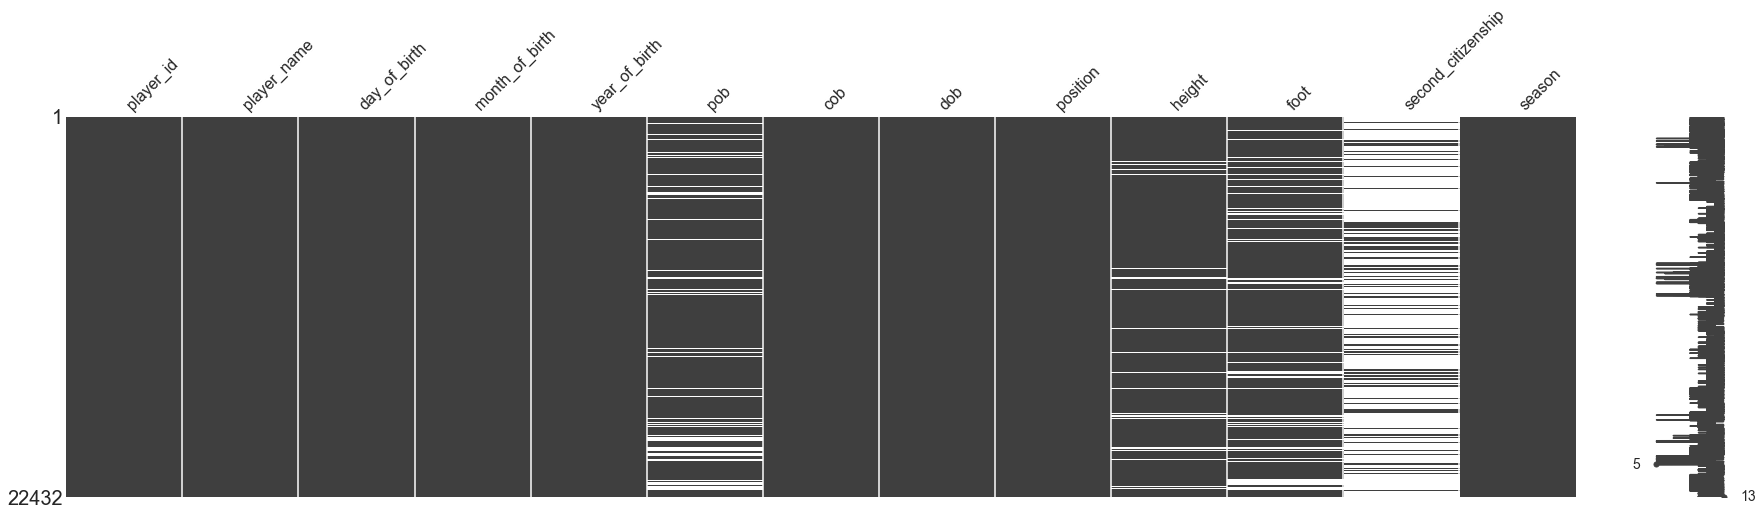

In [17]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_bio_raw
msno.matrix(df_tm_bio_raw, figsize = (30, 7))

In [18]:
# Counts of missing values
tm_bio_null_value_stats = df_tm_bio_raw.isnull().sum(axis=0)
tm_bio_null_value_stats[tm_bio_null_value_stats != 0]

day_of_birth             60
month_of_birth           60
year_of_birth            60
pob                    3415
dob                      60
height                 1468
foot                   3584
second_citizenship    17680
dtype: int64

The visualisation shows us very quickly that there a few missing values in most of the columns, but the dataset is ready for us.

##### Status data

In [19]:
# Display the first 5 rows of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.head()

,player_id,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season
0,580622,skn st. pölten,austria,75000,2020-09-19,2022-06-30,Option for a further year,NaN,NaN,NaN,Agent is known - Player under 18,2020/2021
1,271323,skn st. pölten,austria,500000,2017-07-01,2022-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021
2,192539,skn st. pölten,austria,400000,2020-02-06,2022-06-30,NaN,NaN,NaN,NaN,Good Sportmanagement,2020/2021
3,287995,skn st. pölten,austria,400000,2020-07-28,2022-06-30,NaN,NaN,NaN,NaN,SPOCS Global Sports,2020/2021
4,375434,skn st. pölten,austria,300000,2020-08-19,2023-06-30,NaN,NaN,NaN,NaN,CONNEXION,2020/2021


In [20]:
# Display the last 5 rows of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.tail()

,player_id,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season
21537,177267,ingulets petrove,ukraine,200000,2019-03-01,2021-12-31,NaN,NaN,NaN,NaN,ALIK FOOTBALL MANAGEMENT,2020/2021
21538,380554,ingulets petrove,ukraine,300000,2014-04-01,2021-06-30,NaN,NaN,NaN,NaN,NaN,2020/2021
21539,166563,ingulets petrove,ukraine,200000,2017-09-07,2021-06-30,NaN,NaN,NaN,NaN,S27 Sports Agency,2020/2021
21540,168041,ingulets petrove,ukraine,100000,2020-08-20,2023-06-30,NaN,NaN,NaN,NaN,MSM Group,2020/2021
21541,404851,ingulets petrove,ukraine,300000,2020-10-06,2024-06-30,NaN,zorya lugansk,ukraine,2021-06-30,ProStar,2020/2021


In [21]:
# Print the shape of the raw DataFrame, df_tm_status_raw
print(df_tm_status_raw.shape)

(21542, 12)


In [22]:
# Print the column names of the raw DataFrame, df_tm_status_raw
print(df_tm_status_raw.columns)

Index(['player_id', 'current_club', 'current_club_country', 'market_value',
       'joined', 'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'season'],
      dtype='object')


The dataset has thirteen features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [23]:
# Data types of the features of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.dtypes

player_id                int64
current_club            object
current_club_country    object
market_value             int64
joined                  object
contract_expires        object
contract_option         object
on_loan_from            object
on_loan_from_country    object
loan_contract_expiry    object
player_agent            object
season                  object
dtype: object

All thirteen of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [24]:
# Info for the raw DataFrame, df_tm_status_raw
df_tm_status_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21542 entries, 0 to 21541
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   player_id             21542 non-null  int64 
 1   current_club          21542 non-null  object
 2   current_club_country  21428 non-null  object
 3   market_value          21542 non-null  int64 
 4   joined                21542 non-null  object
 5   contract_expires      18071 non-null  object
 6   contract_option       1513 non-null   object
 7   on_loan_from          1681 non-null   object
 8   on_loan_from_country  1681 non-null   object
 9   loan_contract_expiry  1316 non-null   object
 10  player_agent          15663 non-null  object
 11  season                21542 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.0+ MB


In [25]:
# Description of the raw DataFrame, df_tm_status_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_status_raw.describe()

,player_id,market_value
count,21542.000000,2.154200e+04
mean,311107.638984,1.941129e+06
std,200071.575361,6.473711e+06
min,688.000000,0.000000e+00
25%,142366.250000,1.500000e+05
50%,282552.000000,4.000000e+05
75%,451337.000000,1.000000e+06
max,848812.000000,1.800000e+08


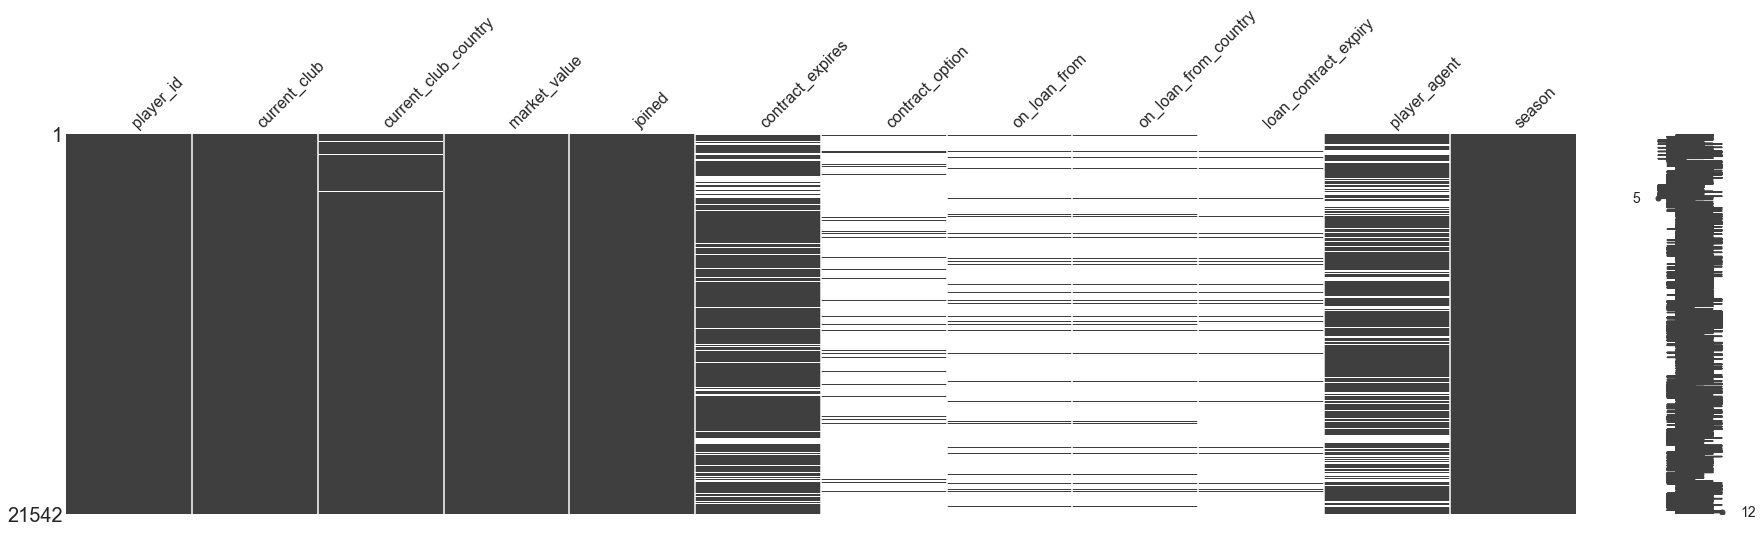

In [26]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_status_raw
msno.matrix(df_tm_status_raw, figsize = (30, 7))

In [27]:
# Counts of missing values
tm_status_null_value_stats = df_tm_status_raw.isnull().sum(axis=0)
tm_status_null_value_stats[tm_status_null_value_stats != 0]

current_club_country      114
contract_expires         3471
contract_option         20029
on_loan_from            19861
on_loan_from_country    19861
loan_contract_expiry    20226
player_agent             5879
dtype: int64

The visualisation shows us very quickly that there a few missing values in most of the columns, but the dataset is ready for us.

### <a id='#section3.3'>3.3. Transfer History Dataset</a>

In [28]:
# WRITE CODE HERE

### <a id='#section3.4'>3.4. Performance Dataset</a>

In [29]:
# WRITE CODE HERE

### <a id='#section3.5'>3.5. Market Value History</a>

In [30]:
# WRITE CODE HERE

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Bio and Status Datasets</a>

#### <a id='#section4.1.1'>4.1.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [41]:
# Assign Raw DataFrames to new Engineered DataFrames
df_tm_bio = df_tm_bio_raw
df_tm_status = df_tm_status_raw

#### <a id='#section4.1.2'>4.1.2. Join Bio and Status Datasets</a>

In [42]:
# Join the Bio and Status DataFrames to form one, unified DataFrame
df_tm_bio_status = pd.merge(df_tm_bio, df_tm_status, left_on='player_id', right_on='player_id', how='left')

In [43]:
df_tm_bio_status.head()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season_x,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season_y
0,580622,emilian metu,18.0,4.0,2003.0,NaN,Austria,2003-04-18,midfield,NaN,NaN,NaN,2020/2021,skn st. pölten,austria,75000.0,2020-09-19,2022-06-30,Option for a further year,NaN,NaN,NaN,Agent is known - Player under 18,2020/2021
1,271323,ahmet muhamedbegovic,30.0,10.0,1998.0,NaN,Austria,1998-10-30,Defender - Centre-Back,186.0,left,NaN,2020/2021,skn st. pölten,austria,500000.0,2017-07-01,2022-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021
2,192539,kofi schulz,21.0,7.0,1989.0,Berlin,Germany,1989-07-21,Defender - Left-Back,188.0,left,Ghana,2020/2021,skn st. pölten,austria,400000.0,2020-02-06,2022-06-30,NaN,NaN,NaN,NaN,Good Sportmanagement,2020/2021
3,287995,manuel maranda,9.0,7.0,1997.0,NaN,Austria,1997-07-09,Defender - Centre-Back,188.0,right,NaN,2020/2021,skn st. pölten,austria,400000.0,2020-07-28,2022-06-30,NaN,NaN,NaN,NaN,SPOCS Global Sports,2020/2021
4,375434,michael steinwender,4.0,5.0,2000.0,Eisenstadt,Austria,2000-05-04,Defender - Centre-Back,190.0,NaN,NaN,2020/2021,skn st. pölten,austria,300000.0,2020-08-19,2023-06-30,NaN,NaN,NaN,NaN,CONNEXION,2020/2021


In [44]:
df_tm_bio_status.shape

(22972, 24)

In [45]:
df_tm_bio_status_notnullvalue = df_tm_bio_status[~df_tm_bio_status['market_value'].isnull()]

In [46]:
df_tm_bio_status_notnullvalue.shape

(22074, 24)

In [47]:
df_tm_bio_status_notnullvalue.head()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season_x,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season_y
0,580622,emilian metu,18.0,4.0,2003.0,NaN,Austria,2003-04-18,midfield,NaN,NaN,NaN,2020/2021,skn st. pölten,austria,75000.0,2020-09-19,2022-06-30,Option for a further year,NaN,NaN,NaN,Agent is known - Player under 18,2020/2021
1,271323,ahmet muhamedbegovic,30.0,10.0,1998.0,NaN,Austria,1998-10-30,Defender - Centre-Back,186.0,left,NaN,2020/2021,skn st. pölten,austria,500000.0,2017-07-01,2022-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021
2,192539,kofi schulz,21.0,7.0,1989.0,Berlin,Germany,1989-07-21,Defender - Left-Back,188.0,left,Ghana,2020/2021,skn st. pölten,austria,400000.0,2020-02-06,2022-06-30,NaN,NaN,NaN,NaN,Good Sportmanagement,2020/2021
3,287995,manuel maranda,9.0,7.0,1997.0,NaN,Austria,1997-07-09,Defender - Centre-Back,188.0,right,NaN,2020/2021,skn st. pölten,austria,400000.0,2020-07-28,2022-06-30,NaN,NaN,NaN,NaN,SPOCS Global Sports,2020/2021
4,375434,michael steinwender,4.0,5.0,2000.0,Eisenstadt,Austria,2000-05-04,Defender - Centre-Back,190.0,NaN,NaN,2020/2021,skn st. pölten,austria,300000.0,2020-08-19,2023-06-30,NaN,NaN,NaN,NaN,CONNEXION,2020/2021


#### <a id='#section4.1.3'>4.1.3. String Cleaning</a>

##### Name

In [48]:
df_tm_bio_status['name_lower'] = df_tm_bio_status['player_name'].str.normalize('NFKD')\
                                                                .str.encode('ascii', errors='ignore')\
                                                                .str.decode('utf-8')\
                                                                .str.lower()

In [49]:
# First Name Lower
df_tm_bio_status['firstname_lower'] = df_tm_bio_status['name_lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_tm_bio_status['lastname_lower'] = df_tm_bio_status['name_lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_tm_bio_status['firstinitial_lower'] = df_tm_bio_status['name_lower'].astype(str).str[0]

##### League Country lower

In [50]:
# Remove accents and create lowercase name
df_tm_bio_status['league_country_lower'] = df_tm_bio_status['current_club_country'].str.normalize('NFKD')\
                                                                                   .str.encode('ascii', errors='ignore')\
                                                                                   .str.decode('utf-8')\
                                                                                   .str.lower()

#### <a id='#section4.1.4'>4.1.4. Converting Data Types</a>

##### Date Time
First we need to convert the `dob` column from the `object` data type to `datetime64[ns]`, again using the [.to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method.

In [51]:
# Convert birth_date from string to datetime64[ns]
df_tm_bio_status['dob'] = pd.to_datetime(df_tm_bio_status['dob'])
df_tm_bio_status['joined'] = pd.to_datetime(df_tm_bio_status['joined'])
df_tm_bio_status['contract_expires'] = pd.to_datetime(df_tm_bio_status['contract_expires'])

##### Numeric
The `value` column needs to be converted from a string to an integer using to [to_numeric()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html) method.

In [52]:
# Convert string to integer
df_tm_bio_status['market_value'] = pd.to_numeric(df_tm_bio_status['market_value'])

#### <a id='#section4.1.5'>4.1.5. Create New Attributes</a>

##### Position Codes

In [53]:
df_tm_bio_status['position'].unique()

array(['midfield', 'Defender - Centre-Back', 'Defender - Left-Back',
       'midfield - Central Midfield', 'Goalkeeper',
       'attack - Left Winger', 'midfield - Attacking Midfield',
       'attack - Centre-Forward', 'Defender - Right-Back',
       'midfield - Defensive Midfield', 'attack - Right Winger',
       'midfield - Left Midfield', 'midfield - Right Midfield', 'attack',
       'Defender', 'attack - Second Striker'], dtype=object)

In [54]:
dict_positions_codes = {'Goalkeeper': 'GK',
                        'Defender': 'DEF',
                        'Defender - Centre-Back': 'CB',
                        'Defender - Left-Back': 'LB',
                        'Defender - Right-Back': 'RB',
                        'midfield': 'MF',
                        'midfield - Central Midfield': 'CM',
                        'midfield - Defensive Midfield': 'CDM',
                        'midfield - Left Midfield': 'LM',
                        'midfield - Right Midfield': 'RM',
                        'midfield - Attacking Midfield': 'CAM',
                        'attack': 'FW',
                        'attack - Left Winger': 'LW',
                        'attack - Right Winger': 'RW',
                        'attack - Second Striker': 'SS',
                        'attack - Centre-Forward': 'ST'
                       }

In [55]:
# Map grouped positions to DataFrame
df_tm_bio_status['position_code'] = df_tm_bio_status['position'].map(dict_positions_codes)

##### Position Grouped

In [56]:
dict_positions_grouped = {
    'Goalkeeper': 'Goalkeeper',
    'Defender': 'Defender',
    'Defender - Centre-Back': 'Defender',
    'Defender - Left-Back': 'Defender',
    'Defender - Right-Back': 'Defender',
    'midfield': 'Midfielder',
    'midfield - Central Midfield': 'Midfielder',
    'midfield - Defensive Midfield': 'Midfielder',
    'midfield - Left Midfield': 'Midfielder',
    'midfield - Right Midfield': 'Midfielder',
    'midfield - Attacking Midfield': 'Midfielder',
    'attack': 'Forward',
    'attack - Left Winger': 'Forward',
    'attack - Right Winger': 'Forward',
    'attack - Second Striker': 'Forward',
    'attack - Centre-Forward': 'Forward'
}

In [57]:
# Map grouped positions to DataFrame
df_tm_bio_status['position_grouped'] = df_tm_bio_status['position'].map(dict_positions_grouped)

##### Goalkeeper / Outfielder

In [58]:
# Separate Goalkeeper and Outfielders
df_tm_bio_status['outfielder_goalkeeper'] = np.where(df_tm_bio_status['position'].isnull(), np.nan, (np.where(df_tm_bio_status['position'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')))
                                                     
                                                     

##### Current Age

In [59]:
now = pd.Timestamp('now')
df_tm_bio_status['dob'] = pd.to_datetime(df_tm_bio_status['dob'], format='%m%d%y')
df_tm_bio_status['dob'] = df_tm_bio_status['dob'].where(df_tm_bio_status['dob'] < now, df_tm_bio_status['dob'] -  np.timedelta64(100, 'Y'))
df_tm_bio_status['age'] = (now - df_tm_bio_status['dob']).astype('<m8[Y]')
df_tm_bio_status['age'] = df_tm_bio_status['age'].astype(np.int64, errors='ignore')

In [60]:
df_tm_bio_status.head()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season_x,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season_y,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age
0,580622,emilian metu,18.0,4.0,2003.0,NaN,Austria,2003-04-18,midfield,NaN,NaN,NaN,2020/2021,skn st. pölten,austria,75000.0,2020-09-19,2022-06-30,Option for a further year,NaN,NaN,NaN,Agent is known - Player under 18,2020/2021,emilian metu,emilian,metu,e,austria,MF,Midfielder,Outfielder,17.0
1,271323,ahmet muhamedbegovic,30.0,10.0,1998.0,NaN,Austria,1998-10-30,Defender - Centre-Back,186.0,left,NaN,2020/2021,skn st. pölten,austria,500000.0,2017-07-01,2022-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021,ahmet muhamedbegovic,ahmet,muhamedbegovic,a,austria,CB,Defender,Outfielder,22.0
2,192539,kofi schulz,21.0,7.0,1989.0,Berlin,Germany,1989-07-21,Defender - Left-Back,188.0,left,Ghana,2020/2021,skn st. pölten,austria,400000.0,2020-02-06,2022-06-30,NaN,NaN,NaN,NaN,Good Sportmanagement,2020/2021,kofi schulz,kofi,schulz,k,austria,LB,Defender,Outfielder,31.0
3,287995,manuel maranda,9.0,7.0,1997.0,NaN,Austria,1997-07-09,Defender - Centre-Back,188.0,right,NaN,2020/2021,skn st. pölten,austria,400000.0,2020-07-28,2022-06-30,NaN,NaN,NaN,NaN,SPOCS Global Sports,2020/2021,manuel maranda,manuel,maranda,m,austria,CB,Defender,Outfielder,23.0
4,375434,michael steinwender,4.0,5.0,2000.0,Eisenstadt,Austria,2000-05-04,Defender - Centre-Back,190.0,NaN,NaN,2020/2021,skn st. pölten,austria,300000.0,2020-08-19,2023-06-30,NaN,NaN,NaN,NaN,CONNEXION,2020/2021,michael steinwender,michael,steinwender,m,austria,CB,Defender,Outfielder,20.0


##### Age When Joining Club

In [61]:
from datetime import datetime, timedelta

In [62]:
df_tm_bio_status['age_when_joining'] = (df_tm_bio_status['joined'] - df_tm_bio_status['dob']) / timedelta(days=365)
df_tm_bio_status['age_when_joining'] = np.floor(df_tm_bio_status['age_when_joining'])      

##### Time Since Joining Club

In [63]:
now = pd.Timestamp('now')
df_tm_bio_status['joined'] = pd.to_datetime(df_tm_bio_status['joined'], format='%m%d%y')
df_tm_bio_status['joined'] = df_tm_bio_status['joined'].where(df_tm_bio_status['joined'] < now, df_tm_bio_status['joined'] -  np.timedelta64(100, 'Y'))
df_tm_bio_status['years_since_joining'] = (now - df_tm_bio_status['joined']).astype('<m8[Y]')
df_tm_bio_status['years_since_joining'] = df_tm_bio_status['years_since_joining'].astype(np.int64, errors='ignore')

##### Time Until Contract Expiry

In [64]:
now = pd.Timestamp('now')
df_tm_bio_status['contract_expires'] = pd.to_datetime(df_tm_bio_status['contract_expires'], format='%m%d%y')
#df_tm_bio_status['contract_expires'] = df_tm_bio_status['contract_expires'].where(df_tm_bio_status['contract_expires'] < now, df_tm_bio_status['contract_expires'] - np.timedelta64(100, 'Y'))
df_tm_bio_status['years_until_contract_expiry'] = (df_tm_bio_status['contract_expires'] - now).astype('<m8[Y]')
df_tm_bio_status['years_until_contract_expiry'] = df_tm_bio_status['years_until_contract_expiry'].astype(np.int64, errors='ignore')

In [65]:
df_tm_bio_status.head(50)

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season_x,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,season_y,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry
0,580622,emilian metu,18.0,4.0,2003.0,NaN,Austria,2003-04-18,midfield,NaN,NaN,NaN,2020/2021,skn st. pölten,austria,75000.0,2020-09-19,2022-06-30,Option for a further year,NaN,NaN,NaN,Agent is known - Player under 18,2020/2021,emilian metu,emilian,metu,e,austria,MF,Midfielder,Outfielder,17.0,17.0,0.0,1.0
1,271323,ahmet muhamedbegovic,30.0,10.0,1998.0,NaN,Austria,1998-10-30,Defender - Centre-Back,186.0,left,NaN,2020/2021,skn st. pölten,austria,500000.0,2017-07-01,2022-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021,ahmet muhamedbegovic,ahmet,muhamedbegovic,a,austria,CB,Defender,Outfielder,22.0,18.0,3.0,1.0
2,192539,kofi schulz,21.0,7.0,1989.0,Berlin,Germany,1989-07-21,Defender - Left-Back,188.0,left,Ghana,2020/2021,skn st. pölten,austria,400000.0,2020-02-06,2022-06-30,NaN,NaN,NaN,NaN,Good Sportmanagement,2020/2021,kofi schulz,kofi,schulz,k,austria,LB,Defender,Outfielder,31.0,30.0,0.0,1.0
3,287995,manuel maranda,9.0,7.0,1997.0,NaN,Austria,1997-07-09,Defender - Centre-Back,188.0,right,NaN,2020/2021,skn st. pölten,austria,400000.0,2020-07-28,2022-06-30,NaN,NaN,NaN,NaN,SPOCS Global Sports,2020/2021,manuel maranda,manuel,maranda,m,austria,CB,Defender,Outfielder,23.0,23.0,0.0,1.0
4,375434,michael steinwender,4.0,5.0,2000.0,Eisenstadt,Austria,2000-05-04,Defender - Centre-Back,190.0,NaN,NaN,2020/2021,skn st. pölten,austria,300000.0,2020-08-19,2023-06-30,NaN,NaN,NaN,NaN,CONNEXION,2020/2021,michael steinwender,michael,steinwender,m,austria,CB,Defender,Outfielder,20.0,20.0,0.0,2.0
5,353634,robert ljubicic,14.0,7.0,1999.0,Wien,Austria,1999-07-14,midfield - Central Midfield,178.0,left,Croatia,2020/2021,skn st. pölten,austria,1000000.0,2018-05-18,2021-06-30,NaN,NaN,NaN,NaN,HAGMAYR Sportmanagement,2020/2021,robert ljubicic,robert,ljubicic,r,austria,CM,Midfielder,Outfielder,21.0,18.0,2.0,0.0
6,159758,armin gremsl,13.0,8.0,1994.0,NaN,Austria,1994-08-13,Goalkeeper,190.0,left,NaN,2020/2021,skn st. pölten,austria,300000.0,2020-07-30,2022-06-30,NaN,NaN,NaN,NaN,arena11 sports group,2020/2021,armin gremsl,armin,gremsl,a,austria,GK,Goalkeeper,Goalkeeper,26.0,25.0,0.0,1.0
7,293602,dor hugi,10.0,7.0,1995.0,Bnei Brak,Israel,1995-07-10,attack - Left Winger,180.0,right,NaN,2020/2021,skn st. pölten,austria,1300000.0,2020-07-30,2022-06-30,NaN,NaN,NaN,NaN,More than Sport GmbH,2020/2021,dor hugi,dor,hugi,d,austria,LW,Forward,Outfielder,25.0,25.0,0.0,1.0
8,308086,christoph halper,21.0,5.0,1998.0,NaN,Austria,1998-05-21,midfield - Attacking Midfield,179.0,right,NaN,2020/2021,skn st. pölten,austria,400000.0,2020-08-12,2022-06-30,NaN,NaN,NaN,NaN,Reza Sport Consulting e.U.,2020/2021,christoph halper,christoph,halper,c,austria,CAM,Midfielder,Outfielder,22.0,22.0,0.0,1.0
9,307939,alexander schmidt,19.0,1.0,1998.0,Wien,Austria,1998-01-19,attack - Centre-Forward,193.0,right,NaN,2020/2021,skn st. pölten,austria,1000000.0,2020-08-16,2023-06-30,NaN,lask,austria,2021-06-30,arena11 sports group,2020/2021,alexander schmidt,alexander,schmidt,a,austria,ST,Forward,Outfielder,22.0,22.0,0.0,2.0


#### <a id='#section4.1.5'>4.1.5. Drop Unnecessary Columns</a>

In [66]:
df_tm_bio_status = df_tm_bio_status.drop(['season_y'], axis=1)

#### <a id='#section4.1.6'>4.1.6. Convert Euros to Pounds</a>

https://forex-python.readthedocs.io/en/latest/usage.html

In [67]:
# Get EUR to GBP exchange rate

## Get latest currency rates
c = CurrencyRates()

##  Get floored conversion rate from EUR to GBP to 2.d.p:
rate = math.floor((c.get_rate('EUR', 'GBP') * 100))/100.0
rate

0.89

In [68]:
# Convert TM.com Euro value to Pounds
df_tm_bio_status['market_value_pounds'] = df_tm_bio_status['market_value'] * rate

Checks:
- On 29th December 2020, the exchange rate for EUR to GBP is 0.90.
- Mohammed Salah is listed on TM.com as [120mil EUR](https://www.transfermarkt.com/mohamed-salah/profil/spieler/148455) and on TM.co.uk as [108mil GBP](https://www.transfermarkt.co.uk/mohamed-salah/profil/spieler/148455).

In [69]:
df_tm_bio_status[df_tm_bio_status['player_name'].str.contains('salah')]

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,second_citizenship,season_x,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
2820,511143,salah aziz binous,4.0,8.0,2000.0,Lugano,Switzerland,2000-08-04,attack - Centre-Forward,192.0,left,Tunisia,2020/2021,fc luzern,switzerland,100000.0,2019-07-01,2022-06-30,NaN,NaN,NaN,NaN,NaN,salah aziz binous,salah,binous,s,switzerland,ST,Forward,Outfielder,20.0,18.0,1.0,1.0,89000.0
8024,148455,mohamed salah,15.0,6.0,1992.0,"Nagrig, Basyoun",Egypt,1992-06-15,attack - Right Winger,175.0,left,NaN,2020/2021,liverpool fc,england,120000000.0,2017-07-01,2023-06-30,NaN,NaN,NaN,NaN,NaN,mohamed salah,mohamed,salah,m,england,RW,Forward,Outfielder,28.0,25.0,3.0,2.0,106800000.0


#### <a id='#section4.1.7'>4.1.7. Rename Columns</a>

In [70]:
df_tm_bio_status = df_tm_bio_status.rename(columns={'player_id': 'tm_id',
                                                    'season_x': 'season',
                                                    'market_value': 'market_value_euros',
                                                    'day_of_birth': 'birth_day',
                                                    'month_of_birth': 'birth_month',
                                                    'year_of_birth': 'birth_year'
                                                   })

#### <a id='#section4.1.9'>4.1.9. Dedupe DataFrame</a>

In [71]:
df_tm_bio_status.shape

(22972, 36)

In [72]:
df_tm_bio_status_dedupe = df_tm_bio_status.drop_duplicates()

In [73]:
df_tm_bio_status_dedupe.shape

(22094, 36)

#### <a id='#section4.1.10'>4.1.10. Filter Players in 'Big 5' European Leagues</a>

In [74]:
# Filter plays in the Big 5 European Leagues

## Define list of countries
lst_big5_countries = ['england', 'germany', 'spain', 'italy', 'france']

## Filter list of Big 5 European League countries from DataFrame
df_tm_bio_status_big5 = df_tm_bio_status_dedupe[df_tm_bio_status_dedupe['current_club_country'].isin(lst_big5_countries)]

In [75]:
df_tm_bio_status_big5.shape

(7284, 36)

#### <a id='#section4.1.10'>4.1.10. Exporting the Engineered DataFrames</a>
Export the two engineered [TransferMarkt](https://www.transfermarkt.co.uk/) DataFrames as CSV files.

In [76]:
# Export DataFrame as a CSV file

## All data

### Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_bio_status_dedupe.to_csv(data_dir_tm + f'/engineered/{short_season_string}/bio-status/archive/' + f'tm_bio_status_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

### Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_bio_status_dedupe.to_csv(data_dir_tm + f'/engineered/{short_season_string}/bio-status/' + f'tm_bio_status_{short_season_string}_latest.csv', index=None, header=True)


## Big 5 European Leagues

### Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_bio_status_big5.to_csv(data_dir_tm + f'/engineered/{short_season_string}/bio-status/archive/' + f'tm_bio_status_big5_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

### Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_bio_status_big5.to_csv(data_dir_tm + f'/engineered/{short_season_string}/bio-status/' + f'tm_bio_status_big5_{short_season_string}_latest.csv', index=None, header=True)

In [77]:
df_tm_bio_status_dedupe.to_csv(data_dir + '/export/tm_bio_status_players_all_latest.csv', index=None, header=True)
df_tm_bio_status_big5.to_csv(data_dir + '/export/tm_bio_status_players_big5_latest.csv', index=None, header=True)

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

### <a id='#section4.2'>4.2. ...</a>

In [78]:
# CODE HERE

### <a id='#section4.3'>4.3. ...</a>

In [79]:
# CODE HERE

### <a id='#section4.4'>4.4. ...</a>

In [80]:
# CODE HERE

## <a id='#section5'>5. Exploratory Data Analysis</a>

In [ ]:
df_tm_bio_status_big5.head()

## <a id='#section6'>6. Summary</a>
This Jupyter notebook engineered scraped football data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

## <a id='#section7'>7. Next Steps</a>
The step is to use this data and match it to FBref, 21st Club, Opta, FIFA, and other datasets.

## <a id='#section8'>8. References</a>

#### Data and Web Scraping
*    [tyrone_mings GitHub repository](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://github.com/FCrSTATS)
*    [Python Package Index (PyPI) tyrone-mings library](https://pypi.org/project/tyrone-mings/)
*    [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann.
*    [06/04/2020: BBC - Premier League squads 'drop £1.6bn in value'](https://www.bbc.co.uk/sport/football/52221463).

#### Forex currency converion
*    [forex-python documentation](https://forex-python.readthedocs.io/en/latest/usage.html)

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)